# 時間ごとのバグ発見数をグラフ化

In [63]:

# 必要なライブラリのインポート
import os
import csv
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib.font_manager as fm

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (12, 8)
print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [64]:
# 拡張版ヒートマップ分析クラス（NULL回数とtimeout回数も含む）

class ExtendedBugTimeAnalyzer:
    """30分あたりのバグ発見数、NULL回数、timeout回数をヒートマップで分析する拡張クラス（tree値別対応）"""
    
    def __init__(self, cpNum_params):
        """
        初期化
        
        Args:
            cpNum_params (list): cpNumパラメータのリスト
        """
        self.logs_path = 'Logs'
        self.cpnum_values = cpNum_params
        self.cpnum_range_values = [1, 50, 99]
        self.cpnum_dir_values = [1, 2, 3, 4]
        self.checkpoints = list(range(1, 11))
        self.tree_values = [0, 500, 1000]
        
        self.parsed_data = []
        
    def parse_directory_name(self, dir_name):
        """ディレクトリ名をパースしてcpNumとcpNum_rangeを抽出"""
        params = dir_name.split(',')
        if len(params) < 30:
            return None, None
            
        try:
            cpnum = None
            cpnum_range = None
            
            for i in range(10):
                if int(params[i]) != 0:
                    cpnum = int(params[i])
                    break
                    
            for i in range(10, 20):
                if int(params[i]) != 0:
                    cpnum_range = int(params[i])
                    break
            
            return cpnum, cpnum_range
        except (ValueError, IndexError):
            return None, None
    
    def load_detected_bugs_within_minutes_data(self, detected_bugs_path, exe_time_path):
        """
        detected_bugs.csvとexe_time.csvを一緒に読み込み、
        バグが発見されている行について、実行時間が30分以内、20分以内、10分以内でそれぞれカウント
        
        Args:
            detected_bugs_path: detected_bugs.csvのパス
            exe_time_path: exe_time.csvのパス
        
        Returns:
            dict: 10分以内、20分以内、30分以内のバグ数のカウント結果
        """
        # カウント用の変数を初期化
        count_within_10min = 0  # 10分以内のバグ数
        count_within_20min = 0  # 20分以内のバグ数
        count_within_30min = 0  # 30分以内のバグ数
        
        # フレームレート（60fps）
        fps = 60.0
        
        # 時間の閾値（秒単位）
        threshold_10min = 10 * 60  # 10分 = 600秒
        threshold_20min = 20 * 60  # 20分 = 1200秒
        threshold_30min = 30 * 60  # 30分 = 1800秒
        
        try:
            # exe_time.csvを読み込んでフレーム数のリストを作成
            exe_times = []
            with open(exe_time_path, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if line:  # 空行でない場合
                        try:
                            exe_times.append(int(line))
                        except ValueError:
                            # 数値に変換できない場合は0として扱う
                            exe_times.append(0)
            
            # detected_bugs.csvを読み込んで、行ごとに処理
            with open(detected_bugs_path, 'r', encoding='utf-8') as csvfile:
                reader = csv.reader(csvfile)
                
                for row_index, row in enumerate(reader):
                    # 対応する行の実行時間（フレーム数）を取得
                    frames = exe_times[row_index]
                    
                    time_seconds = frames / fps
                    
                    # バグが発見されている行かどうかを判定
                    # "null"でも"timeout"でもなく、かつ空でない行がバグ
                    is_bug = False
                    if row and row != ["null"] and row != ["timeout"]:
                        # 空のリストでない、かつ"null"でも"timeout"でもない場合はバグ
                        if len(row) > 0 and row[0].strip():
                            is_bug = True
                    
                    # バグが発見されている場合、時間でカウント
                    if is_bug:
                        if time_seconds <= threshold_10min:
                            count_within_10min += 1
                        elif time_seconds <= threshold_20min:
                            count_within_20min += 1
                        elif time_seconds <= threshold_30min:
                            count_within_30min += 1
                            
        except FileNotFoundError:
            return None
        except Exception as e:
            print(f"エラーが発生しました: {e}")
            return None
        
        return {
            'within_10min': count_within_10min,
            'within_20min': count_within_20min,
            'within_30min': count_within_30min
        }
    
    def collect_data(self):
        """全てのログディレクトリからデータを収集（tree値別）"""
        # データをリセット（重複を防ぐため）
        self.parsed_data = []
        
        print("データ収集を開始しています...")
        
        if not os.path.exists(self.logs_path):
            raise FileNotFoundError(f"ログディレクトリが見つかりません: {self.logs_path}")
        
        total_processed = 0
        total_directories = 0
        
        # 各tree値に対して処理
        for tree in self.tree_values:
            tree_path = os.path.join(self.logs_path, f"tree={tree}")
            
            if not os.path.exists(tree_path):
                print(f"警告: {tree_path} が見つかりません。スキップします。")
                continue
            
            print(f"  tree={tree} のディレクトリを処理中...")
            processed_count = 0
            directories_in_tree = len([d for d in os.listdir(tree_path) 
                                     if os.path.isdir(os.path.join(tree_path, d))])
            total_directories += directories_in_tree
            
            for dir_name in os.listdir(tree_path):
                dir_path = os.path.join(tree_path, dir_name)
                
                if not os.path.isdir(dir_path):
                    continue
                    
                # ディレクトリ名をパース
                cpnum, cpnum_range = self.parse_directory_name(dir_name)
                if cpnum is None or cpnum_range is None:
                    continue
                    
                # detected_bugs.csvファイルのパス
                detected_bugs_path = os.path.join(dir_path, 'detected_bugs.csv')

                # exe_time.csvから実行時間を取得(実行フレーム数)
                exe_time_path = os.path.join(dir_path, 'exe_time.csv')
                
                # データ読み込み
                data = self.load_detected_bugs_within_minutes_data(detected_bugs_path, exe_time_path)
                if data is None:
                    continue
                

                
                self.parsed_data.append({
                    'tree': tree,
                    'cpnum': cpnum,
                    'cpnum_range': cpnum_range,
                    'within_10min': data['within_10min'],
                    'within_20min': data['within_20min'],
                    'within_30min': data['within_30min'],
                })
                processed_count += 1
                total_processed += 1
            
            print(f"  tree={tree}: {processed_count}/{directories_in_tree} ディレクトリを処理しました")
            
        print(f"データ収集完了: 合計 {total_processed}/{total_directories} ディレクトリを処理しました")
    
    
    def create_pie_charts_by_tree(self):
        """
        Treeごとのバグ発見時間の割合を円グラフで表示（3つのグラフを横並びに）
        """
        if not self.parsed_data:
            print("エラー: データが収集されていません。先にcollect_data()を実行してください。")
            return
        
        parsed_df = pd.DataFrame(self.parsed_data)
        
        # 3つのグラフを横並びに配置
        _, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 共通の色とラベルを定義
        labels = ['10分以内', '10-20分', '20-30分']
        colors = ['#ff9999', '#66b3ff', '#99ff99']
        
        # Treeごとにデータを集計してグラフを作成
        for idx, tree in enumerate(self.tree_values):
            tree_df = parsed_df[parsed_df['tree'] == tree]
            
            if len(tree_df) == 0:
                axes[idx].text(0.5, 0.5, f'Tree={tree}\nデータなし', 
                              ha='center', va='center', fontsize=14)
                axes[idx].set_title(f'Tree={tree}', fontsize=14, fontweight='bold')
                continue
            
            # 各時間帯のバグ数を計算（累積値から差分を取る）
            total_10min = tree_df['within_10min'].sum()
            total_20min = tree_df['within_20min'].sum()
            total_30min = tree_df['within_30min'].sum()
            
            bugs_10min = total_10min  # 10分以内
            bugs_10_20min = total_20min  # 10分超20分以内
            bugs_20_30min = total_30min  # 20分超30分以内
            
            # データを準備
            sizes = [bugs_10min, bugs_10_20min, bugs_20_30min]
            
            # 0の値を除外
            filtered_data = [(label, size, color) for label, size, color in zip(labels, sizes, colors) if size > 0]
            if not filtered_data:
                axes[idx].text(0.5, 0.5, f'Tree={tree}\nデータなし', 
                              ha='center', va='center', fontsize=14)
                axes[idx].set_title(f'Tree={tree}', fontsize=14, fontweight='bold')
                continue
            
            labels_filtered, sizes_filtered, colors_filtered = zip(*filtered_data)
            
            # パーセンテージと件数を表示するカスタム関数
            def make_autopct(sizes):
                total = sum(sizes)
                def my_autopct(pct):
                    val = int(round(pct * total / 100.0))
                    return f'{pct:.1f}%\n({val}件)'
                return my_autopct
            
            # 円グラフを作成
            wedges, texts, autotexts = axes[idx].pie(
                sizes_filtered,
                labels=labels_filtered,
                colors=colors_filtered,
                autopct=make_autopct(sizes_filtered),
                startangle=90,
                textprops={'fontsize': 10, 'fontweight': 'bold'}
            )
            
            # パーセンテージと件数の表示を調整
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontsize(11)
                autotext.set_fontweight('bold')
            
            axes[idx].set_title(f'Tree={tree} のバグ発見時間の割合\n(総バグ数: {total_30min}件)', 
                              fontsize=14, fontweight='bold', pad=15)
            
            # 統計情報を表示
            print(f"\ntree={tree} の統計:")
            print(f"  10分以内: {bugs_10min}件 ({bugs_10min/total_30min*100:.1f}%)")
            print(f"  10-20分: {bugs_10_20min}件 ({bugs_10_20min/total_30min*100:.1f}%)")
            print(f"  20-30分: {bugs_20_30min}件 ({bugs_20_30min/total_30min*100:.1f}%)")
            print(f"  合計: {total_30min}件")
        
        plt.suptitle('Treeごとのバグ発見時間の割合', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()

        plt.show()
    
    def create_pie_charts_by_parameter(self):
        """
        パラメータ（cpnum, cpnum_range）ごとのバグ発見時間の割合を円グラフで表示
        cpNumは主要な3つ（1, 50, 99）を横並びに、cpNum_rangeは3つすべてを横並びに
        """
        if not self.parsed_data:
            print("エラー: データが収集されていません。先にcollect_data()を実行してください。")
            return
        
        parsed_df = pd.DataFrame(self.parsed_data)
        
        # 共通の色とラベルを定義
        labels = ['10分以内', '10-20分', '20-30分']
        colors = ['#ff9999', '#66b3ff', '#99ff99']
        
        # cpnumごとに集計
        print("\n=== cpNumパラメータごとの円グラフ ===")

        cpnums = [1, 50, 99, 200, 300, 700]
        cpnums_to_plot = [cpnum for cpnum in cpnums]
        
        if len(cpnums_to_plot) > 0:
            fig, axes = plt.subplots(1, len(cpnums_to_plot), figsize=(6*len(cpnums_to_plot), 6))
            if len(cpnums_to_plot) == 1:
                axes = [axes]  # 1つの場合の処理
            
            for idx, cpnum in enumerate(cpnums_to_plot):
                cpnum_df = parsed_df[parsed_df['cpnum'] == cpnum]
                
                if len(cpnum_df) == 0:
                    axes[idx].text(0.5, 0.5, f'cpNum={cpnum}\nデータなし', 
                                  ha='center', va='center', fontsize=14)
                    axes[idx].set_title(f'cpNum={cpnum}', fontsize=14, fontweight='bold')
                    continue
                
                # 各時間帯のバグ数を計算
                total_10min = cpnum_df['within_10min'].sum()
                total_20min = cpnum_df['within_20min'].sum()
                total_30min = cpnum_df['within_30min'].sum()
                
                bugs_10min = total_10min
                bugs_10_20min = total_20min
                bugs_20_30min = total_30min
                
                # データを準備
                sizes = [bugs_10min, bugs_10_20min, bugs_20_30min]
                
                # 0の値を除外
                filtered_data = [(label, size, color) for label, size, color in zip(labels, sizes, colors) if size > 0]
                if not filtered_data:
                    axes[idx].text(0.5, 0.5, f'cpNum={cpnum}\nデータなし', 
                                  ha='center', va='center', fontsize=14)
                    axes[idx].set_title(f'cpNum={cpnum}', fontsize=14, fontweight='bold')
                    continue
                
                labels_filtered, sizes_filtered, colors_filtered = zip(*filtered_data)
                
                # パーセンテージと件数を表示するカスタム関数
                def make_autopct(sizes):
                    total = sum(sizes)
                    def my_autopct(pct):
                        val = int(round(pct * total / 100.0))
                        return f'{pct:.1f}%\n({val}件)'
                    return my_autopct
                
                # 円グラフを作成
                wedges, texts, autotexts = axes[idx].pie(
                    sizes_filtered,
                    labels=labels_filtered,
                    colors=colors_filtered,
                    autopct=make_autopct(sizes_filtered),
                    startangle=90,
                    textprops={'fontsize': 10, 'fontweight': 'bold'}
                )
                
                for autotext in autotexts:
                    autotext.set_color('white')
                    autotext.set_fontsize(11)
                    autotext.set_fontweight('bold')
                
                axes[idx].set_title(f'cpNum={cpnum} のバグ発見時間の割合\n(総バグ数: {total_30min}件)', 
                                  fontsize=14, fontweight='bold', pad=15)
                
                print(f"  cpNum={cpnum}: 10分以内={bugs_10min}件, 10-20分={bugs_10_20min}件, 20-30分={bugs_20_30min}件 (合計={total_30min}件)")
            
            plt.suptitle('cpNumパラメータごとのバグ発見時間の割合', fontsize=16, fontweight='bold', y=1.02)
            plt.tight_layout()

            plt.show()
        
        # cpnum_rangeごとに集計（3つすべてを横並びに）
        print("\n=== cpNum_rangeパラメータごとの円グラフ ===")
        cpnum_range_values = sorted(parsed_df['cpnum_range'].unique())
        
        if len(cpnum_range_values) > 0:
            fig, axes = plt.subplots(1, len(cpnum_range_values), figsize=(6*len(cpnum_range_values), 6))
            if len(cpnum_range_values) == 1:
                axes = [axes]  # 1つの場合の処理
            
            for idx, cpnum_range in enumerate(cpnum_range_values):
                range_df = parsed_df[parsed_df['cpnum_range'] == cpnum_range]
                
                if len(range_df) == 0:
                    axes[idx].text(0.5, 0.5, f'cpNum_range={cpnum_range}\nデータなし', 
                                  ha='center', va='center', fontsize=14)
                    axes[idx].set_title(f'cpNum_range={cpnum_range}', fontsize=14, fontweight='bold')
                    continue
                
                # 各時間帯のバグ数を計算
                total_10min = range_df['within_10min'].sum()
                total_20min = range_df['within_20min'].sum()
                total_30min = range_df['within_30min'].sum()
                
                bugs_10min = total_10min
                bugs_10_20min = total_20min
                bugs_20_30min = total_30min
                
                # データを準備
                sizes = [bugs_10min, bugs_10_20min, bugs_20_30min]
                
                # 0の値を除外
                filtered_data = [(label, size, color) for label, size, color in zip(labels, sizes, colors) if size > 0]
                if not filtered_data:
                    axes[idx].text(0.5, 0.5, f'cpNum_range={cpnum_range}\nデータなし', 
                                  ha='center', va='center', fontsize=14)
                    axes[idx].set_title(f'cpNum_range={cpnum_range}', fontsize=14, fontweight='bold')
                    continue
                
                labels_filtered, sizes_filtered, colors_filtered = zip(*filtered_data)
                
                # パーセンテージと件数を表示するカスタム関数
                def make_autopct(sizes):
                    total = sum(sizes)
                    def my_autopct(pct):
                        val = int(round(pct * total / 100.0))
                        return f'{pct:.1f}%\n({val}件)'
                    return my_autopct
                
                # 円グラフを作成
                wedges, texts, autotexts = axes[idx].pie(
                    sizes_filtered,
                    labels=labels_filtered,
                    colors=colors_filtered,
                    autopct=make_autopct(sizes_filtered),
                    startangle=90,
                    textprops={'fontsize': 10, 'fontweight': 'bold'}
                )
                
                for autotext in autotexts:
                    autotext.set_color('white')
                    autotext.set_fontsize(11)
                    autotext.set_fontweight('bold')
                
                axes[idx].set_title(f'cpNum_range={cpnum_range} のバグ発見時間の割合\n(総バグ数: {total_30min}件)', 
                                  fontsize=14, fontweight='bold', pad=15)
                
                print(f"  cpNum_range={cpnum_range}: 10分以内={bugs_10min}件, 10-20分={bugs_10_20min}件, 20-30分={bugs_20_30min}件 (合計={total_30min}件)")
            
            plt.suptitle('cpNum_rangeパラメータごとのバグ発見時間の割合', fontsize=16, fontweight='bold', y=1.02)
            plt.tight_layout()

            plt.show()
    
    def create_line_charts_by_tree(self):
        """
        Treeごとのバグ発見時間の割合を折れ線グラフで表示
        横軸：Treeの値、縦軸：バグ発見数
        時間帯ごとに3本の折れ線（10分以内、10-20分、20-30分）を描画
        """
        if not self.parsed_data:
            print("エラー: データが収集されていません。先にcollect_data()を実行してください。")
            return
        
        parsed_df = pd.DataFrame(self.parsed_data)
        
        # グラフを作成
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # 時間帯ごとのデータを準備
        bugs_10min_list = []
        bugs_10_20min_list = []
        bugs_20_30min_list = []
        
        for tree in self.tree_values:
            tree_df = parsed_df[parsed_df['tree'] == tree]
            
            if len(tree_df) == 0:
                bugs_10min_list.append(0)
                bugs_10_20min_list.append(0)
                bugs_20_30min_list.append(0)
                continue
            
            # 各時間帯のバグ数を計算
            total_10min = tree_df['within_10min'].sum()
            total_20min = tree_df['within_20min'].sum()
            total_30min = tree_df['within_30min'].sum()
            
            bugs_10min = total_10min  # 10分以内
            bugs_10_20min = total_20min  # 10分超20分以内
            bugs_20_30min = total_30min  # 20分超30分以内
            
            bugs_10min_list.append(bugs_10min)
            bugs_10_20min_list.append(bugs_10_20min)
            bugs_20_30min_list.append(bugs_20_30min)
        
        # 時間帯ごとに折れ線グラフを描画
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
        labels = ['10分以内', '10-20分', '20-30分']
        
        ax.plot(self.tree_values, bugs_10min_list, marker='o', linewidth=2.5, markersize=8, 
               label=labels[0], color=colors[0])
        ax.plot(self.tree_values, bugs_10_20min_list, marker='s', linewidth=2.5, markersize=8, 
               label=labels[1], color=colors[1])
        ax.plot(self.tree_values, bugs_20_30min_list, marker='^', linewidth=2.5, markersize=8, 
               label=labels[2], color=colors[2])
        
        # 各ポイントに値を表示
        for i, tree in enumerate(self.tree_values):
            if bugs_10min_list[i] > 0:
                ax.text(tree, bugs_10min_list[i], f'{int(bugs_10min_list[i])}', 
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
            if bugs_10_20min_list[i] > 0:
                ax.text(tree, bugs_10_20min_list[i], f'{int(bugs_10_20min_list[i])}', 
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
            if bugs_20_30min_list[i] > 0:
                ax.text(tree, bugs_20_30min_list[i], f'{int(bugs_20_30min_list[i])}', 
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # グラフの設定
        ax.set_xlabel('Tree', fontsize=12, fontweight='bold')
        ax.set_ylabel('バグ発見数', fontsize=12, fontweight='bold')
        ax.set_title('Treeごとのバグ発見時間の割合（折れ線グラフ）', fontsize=14, fontweight='bold', pad=15)
        ax.set_xticks(self.tree_values)
        ax.legend(loc='best', fontsize=11)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
    
    def create_line_charts_by_parameter(self):
        """
        パラメータ（cpnum, cpnum_range）ごとのバグ発見時間の割合を折れ線グラフで表示
        横軸：cpNumまたはcpNum_range、縦軸：バグ発見数
        時間帯ごとに3本の折れ線（10分以内、10-20分、20-30分）を描画
        """
        if not self.parsed_data:
            print("エラー: データが収集されていません。先にcollect_data()を実行してください。")
            return
        
        parsed_df = pd.DataFrame(self.parsed_data)
        
        # cpnumごとの折れ線グラフを作成
        print("\n=== cpNumパラメータごとの折れ線グラフ ===")
        
        cpnums = [1, 50, 99, 200, 300, 700]
        cpnums_to_plot = sorted([cpnum for cpnum in cpnums if cpnum in parsed_df['cpnum'].values])
        
        if len(cpnums_to_plot) > 0:
            fig, ax = plt.subplots(figsize=(12, 7))
            
            # 時間帯ごとのデータを準備
            bugs_10min_list = []
            bugs_10_20min_list = []
            bugs_20_30min_list = []
            
            for cpnum in cpnums_to_plot:
                cpnum_df = parsed_df[parsed_df['cpnum'] == cpnum]
                
                if len(cpnum_df) == 0:
                    bugs_10min_list.append(0)
                    bugs_10_20min_list.append(0)
                    bugs_20_30min_list.append(0)
                    continue
                
                # 各時間帯のバグ数を計算
                total_10min = cpnum_df['within_10min'].sum()
                total_20min = cpnum_df['within_20min'].sum()
                total_30min = cpnum_df['within_30min'].sum()
                
                bugs_10min = total_10min
                bugs_10_20min = total_20min
                bugs_20_30min = total_30min
                
                bugs_10min_list.append(bugs_10min)
                bugs_10_20min_list.append(bugs_10_20min)
                bugs_20_30min_list.append(bugs_20_30min)
            
            # 時間帯ごとに折れ線グラフを描画
            colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
            labels = ['10分以内', '10-20分', '20-30分']
            
            ax.plot(cpnums_to_plot, bugs_10min_list, marker='o', linewidth=2.5, markersize=8, 
                   label=labels[0], color=colors[0])
            ax.plot(cpnums_to_plot, bugs_10_20min_list, marker='s', linewidth=2.5, markersize=8, 
                   label=labels[1], color=colors[1])
            ax.plot(cpnums_to_plot, bugs_20_30min_list, marker='^', linewidth=2.5, markersize=8, 
                   label=labels[2], color=colors[2])
            
            # 各ポイントに値を表示
            for i, cpnum in enumerate(cpnums_to_plot):
                if bugs_10min_list[i] > 0:
                    ax.text(cpnum, bugs_10min_list[i], f'{int(bugs_10min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
                if bugs_10_20min_list[i] > 0:
                    ax.text(cpnum, bugs_10_20min_list[i], f'{int(bugs_10_20min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
                if bugs_20_30min_list[i] > 0:
                    ax.text(cpnum, bugs_20_30min_list[i], f'{int(bugs_20_30min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # グラフの設定
            ax.set_xlabel('cpNum', fontsize=12, fontweight='bold')
            ax.set_ylabel('バグ発見数', fontsize=12, fontweight='bold')
            ax.set_title('cpNumパラメータごとのバグ発見時間の割合（折れ線グラフ）', fontsize=14, fontweight='bold', pad=15)
            ax.set_xticks(cpnums_to_plot)
            ax.legend(loc='best', fontsize=11)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            plt.tight_layout()
            plt.show()
        
        # cpnum_rangeごとの折れ線グラフを作成
        print("\n=== cpNum_rangeパラメータごとの折れ線グラフ ===")
        cpnum_range_values = sorted(parsed_df['cpnum_range'].unique())
        
        if len(cpnum_range_values) > 0:
            fig, ax = plt.subplots(figsize=(10, 7))
            
            # 時間帯ごとのデータを準備
            bugs_10min_list = []
            bugs_10_20min_list = []
            bugs_20_30min_list = []
            
            for cpnum_range in cpnum_range_values:
                range_df = parsed_df[parsed_df['cpnum_range'] == cpnum_range]
                
                if len(range_df) == 0:
                    bugs_10min_list.append(0)
                    bugs_10_20min_list.append(0)
                    bugs_20_30min_list.append(0)
                    continue
                
                # 各時間帯のバグ数を計算
                total_10min = range_df['within_10min'].sum()
                total_20min = range_df['within_20min'].sum()
                total_30min = range_df['within_30min'].sum()
                
                bugs_10min = total_10min
                bugs_10_20min = total_20min
                bugs_20_30min = total_30min
                
                bugs_10min_list.append(bugs_10min)
                bugs_10_20min_list.append(bugs_10_20min)
                bugs_20_30min_list.append(bugs_20_30min)
            
            # 時間帯ごとに折れ線グラフを描画
            colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
            labels = ['10分以内', '10-20分', '20-30分']
            
            ax.plot(cpnum_range_values, bugs_10min_list, marker='o', linewidth=2.5, markersize=8, 
                   label=labels[0], color=colors[0])
            ax.plot(cpnum_range_values, bugs_10_20min_list, marker='s', linewidth=2.5, markersize=8, 
                   label=labels[1], color=colors[1])
            ax.plot(cpnum_range_values, bugs_20_30min_list, marker='^', linewidth=2.5, markersize=8, 
                   label=labels[2], color=colors[2])
            
            # 各ポイントに値を表示
            for i, cpnum_range in enumerate(cpnum_range_values):
                if bugs_10min_list[i] > 0:
                    ax.text(cpnum_range, bugs_10min_list[i], f'{int(bugs_10min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
                if bugs_10_20min_list[i] > 0:
                    ax.text(cpnum_range, bugs_10_20min_list[i], f'{int(bugs_10_20min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
                if bugs_20_30min_list[i] > 0:
                    ax.text(cpnum_range, bugs_20_30min_list[i], f'{int(bugs_20_30min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # グラフの設定
            ax.set_xlabel('cpNum_range', fontsize=12, fontweight='bold')
            ax.set_ylabel('バグ発見数', fontsize=12, fontweight='bold')
            ax.set_title('cpNum_rangeパラメータごとのバグ発見時間の割合（折れ線グラフ）', fontsize=14, fontweight='bold', pad=15)
            ax.set_xticks(cpnum_range_values)
            ax.legend(loc='best', fontsize=11)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            plt.tight_layout()
            plt.show()


In [65]:
# cpNumパラメータを設定
cpNum_params = [1, 50, 99, 200, 300, 700]

# 拡張版分析クラスのインスタンスを作成
extended_analyzer = ExtendedBugTimeAnalyzer(cpNum_params)


Treeごとのバグ発見時間の割合を折れ線グラフで表示します
データ収集を開始しています...
  tree=0 のディレクトリを処理中...
  tree=0: 720/720 ディレクトリを処理しました
  tree=500 のディレクトリを処理中...
  tree=500: 720/720 ディレクトリを処理しました
  tree=1000 のディレクトリを処理中...
  tree=1000: 720/720 ディレクトリを処理しました
データ収集完了: 合計 2160/2160 ディレクトリを処理しました


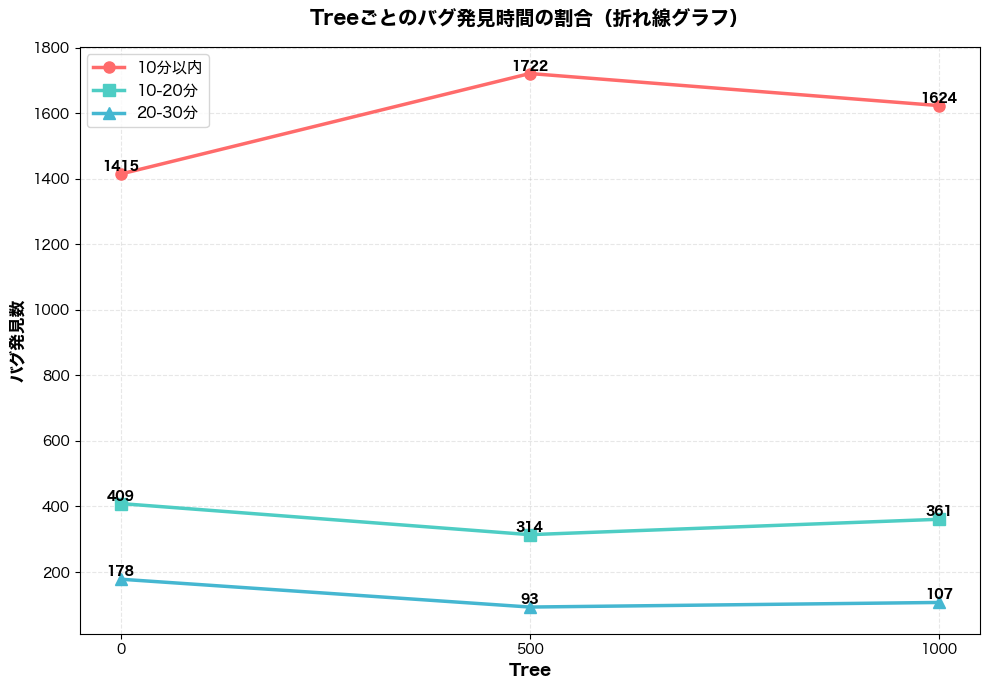

In [66]:
# Treeごとのバグ発見時間の割合を折れ線グラフで表示
print("="*60)
print("Treeごとのバグ発見時間の割合を折れ線グラフで表示します")
print("="*60)
extended_analyzer.collect_data()
extended_analyzer.create_line_charts_by_tree()


データ収集を開始しています...
  tree=0 のディレクトリを処理中...
  tree=0: 720/720 ディレクトリを処理しました
  tree=500 のディレクトリを処理中...
  tree=500: 720/720 ディレクトリを処理しました
  tree=1000 のディレクトリを処理中...
  tree=1000: 720/720 ディレクトリを処理しました
データ収集完了: 合計 2160/2160 ディレクトリを処理しました
Treeごとのバグ発見時間の割合を円グラフで表示します

tree=0 の統計:
  10分以内: 1415件 (794.9%)
  10-20分: 409件 (229.8%)
  20-30分: 178件 (100.0%)
  合計: 178件

tree=500 の統計:
  10分以内: 1722件 (1851.6%)
  10-20分: 314件 (337.6%)
  20-30分: 93件 (100.0%)
  合計: 93件

tree=1000 の統計:
  10分以内: 1624件 (1517.8%)
  10-20分: 361件 (337.4%)
  20-30分: 107件 (100.0%)
  合計: 107件


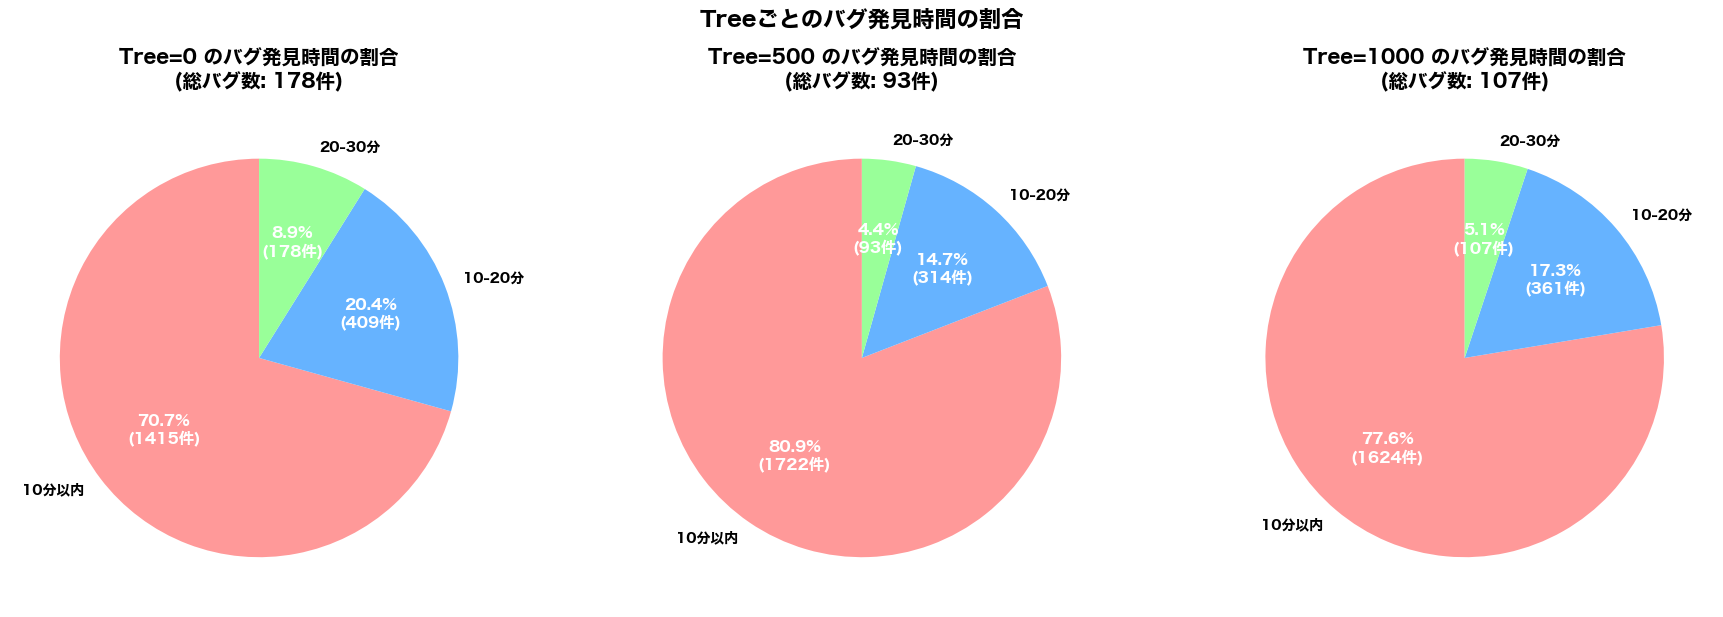

In [67]:
# データ収集
extended_analyzer.collect_data()

# Treeごとのバグ発見時間の割合を円グラフで表示
print("="*60)
print("Treeごとのバグ発見時間の割合を円グラフで表示します")
print("="*60)
extended_analyzer.create_pie_charts_by_tree()


パラメータごとのバグ発見時間の割合を折れ線グラフで表示します

=== cpNumパラメータごとの折れ線グラフ ===


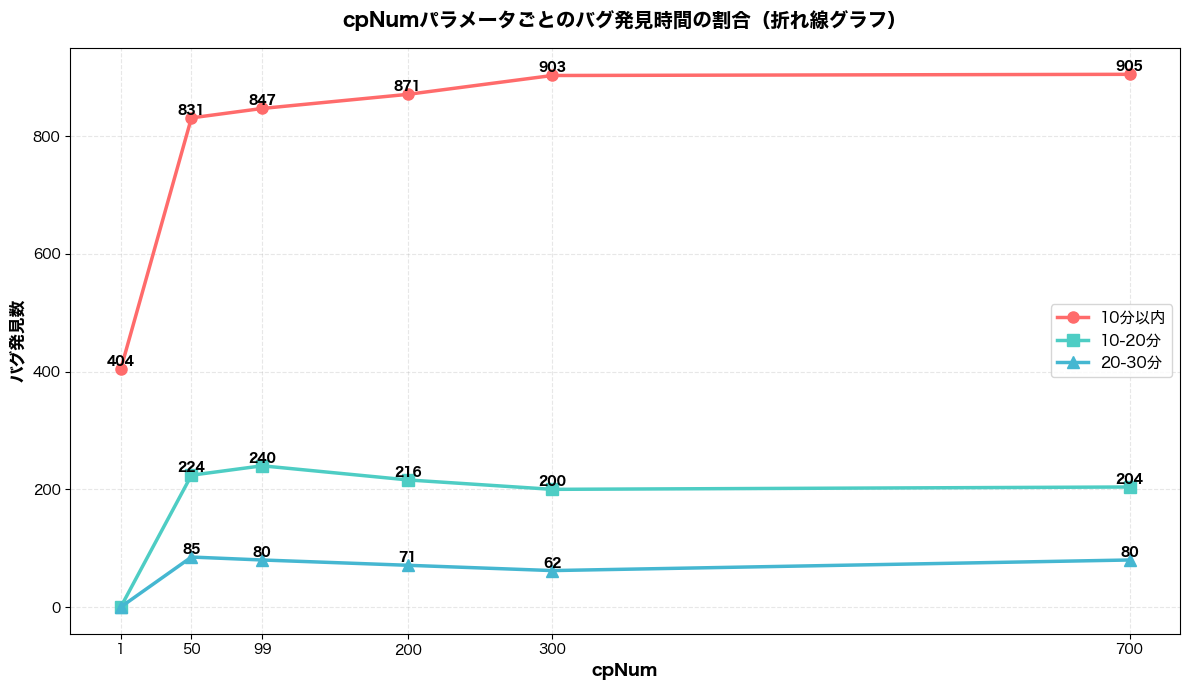


=== cpNum_rangeパラメータごとの折れ線グラフ ===


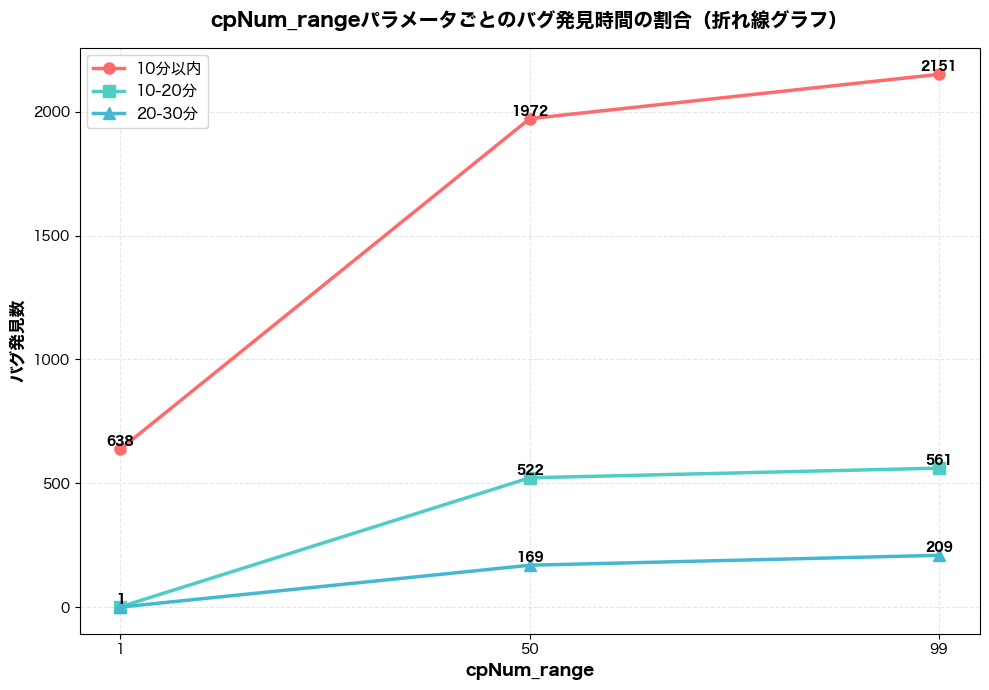

In [68]:
# パラメータごとのバグ発見時間の割合を折れ線グラフで表示
print("="*60)
print("パラメータごとのバグ発見時間の割合を折れ線グラフで表示します")
print("="*60)
extended_analyzer.create_line_charts_by_parameter()


パラメータごとのバグ発見時間の割合を円グラフで表示します

=== cpNumパラメータごとの円グラフ ===
  cpNum=1: 10分以内=404件, 10-20分=0件, 20-30分=0件 (合計=0件)
  cpNum=50: 10分以内=831件, 10-20分=224件, 20-30分=85件 (合計=85件)
  cpNum=99: 10分以内=847件, 10-20分=240件, 20-30分=80件 (合計=80件)
  cpNum=200: 10分以内=871件, 10-20分=216件, 20-30分=71件 (合計=71件)
  cpNum=300: 10分以内=903件, 10-20分=200件, 20-30分=62件 (合計=62件)
  cpNum=700: 10分以内=905件, 10-20分=204件, 20-30分=80件 (合計=80件)


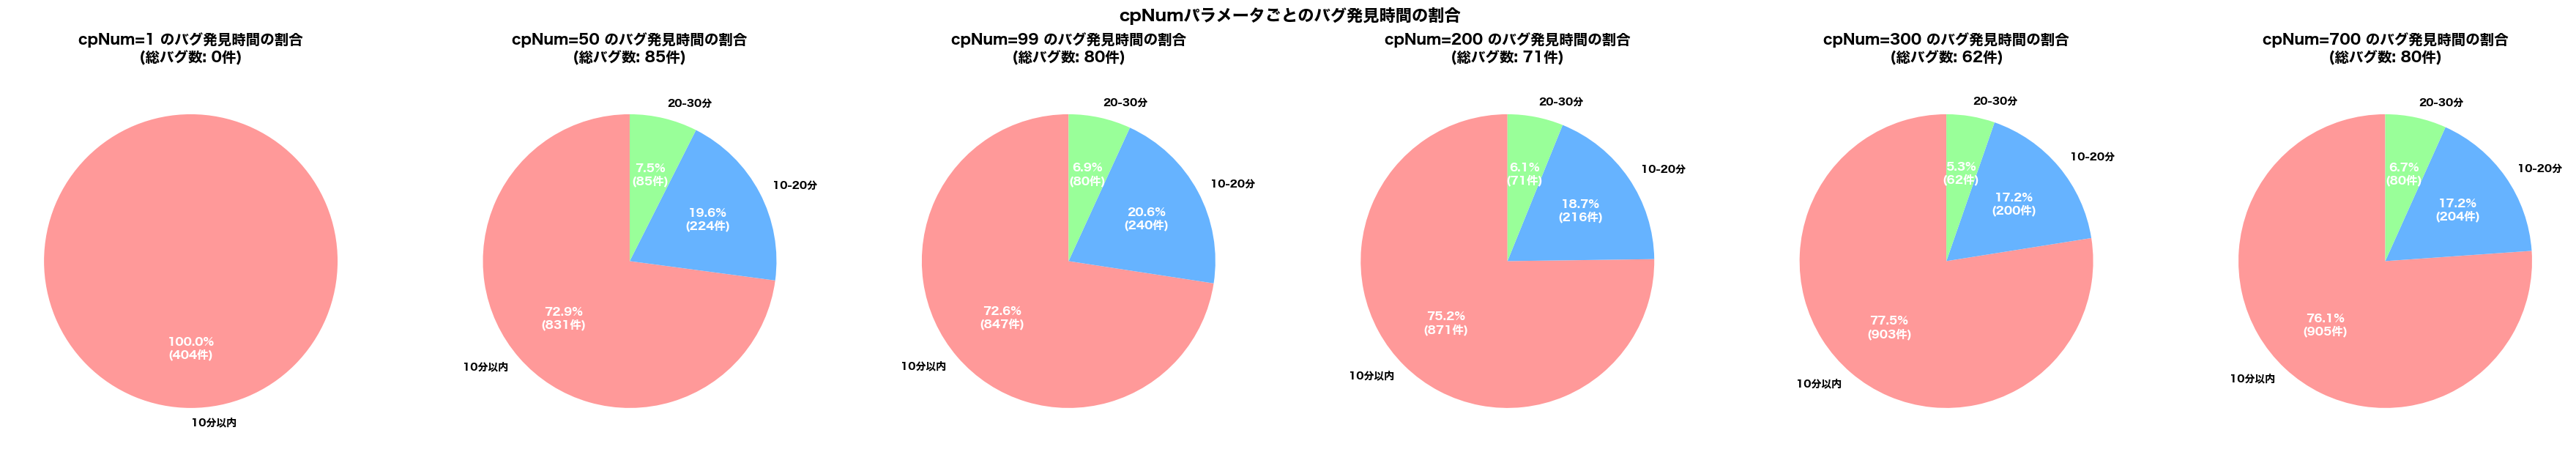


=== cpNum_rangeパラメータごとの円グラフ ===
  cpNum_range=1: 10分以内=638件, 10-20分=1件, 20-30分=0件 (合計=0件)
  cpNum_range=50: 10分以内=1972件, 10-20分=522件, 20-30分=169件 (合計=169件)
  cpNum_range=99: 10分以内=2151件, 10-20分=561件, 20-30分=209件 (合計=209件)


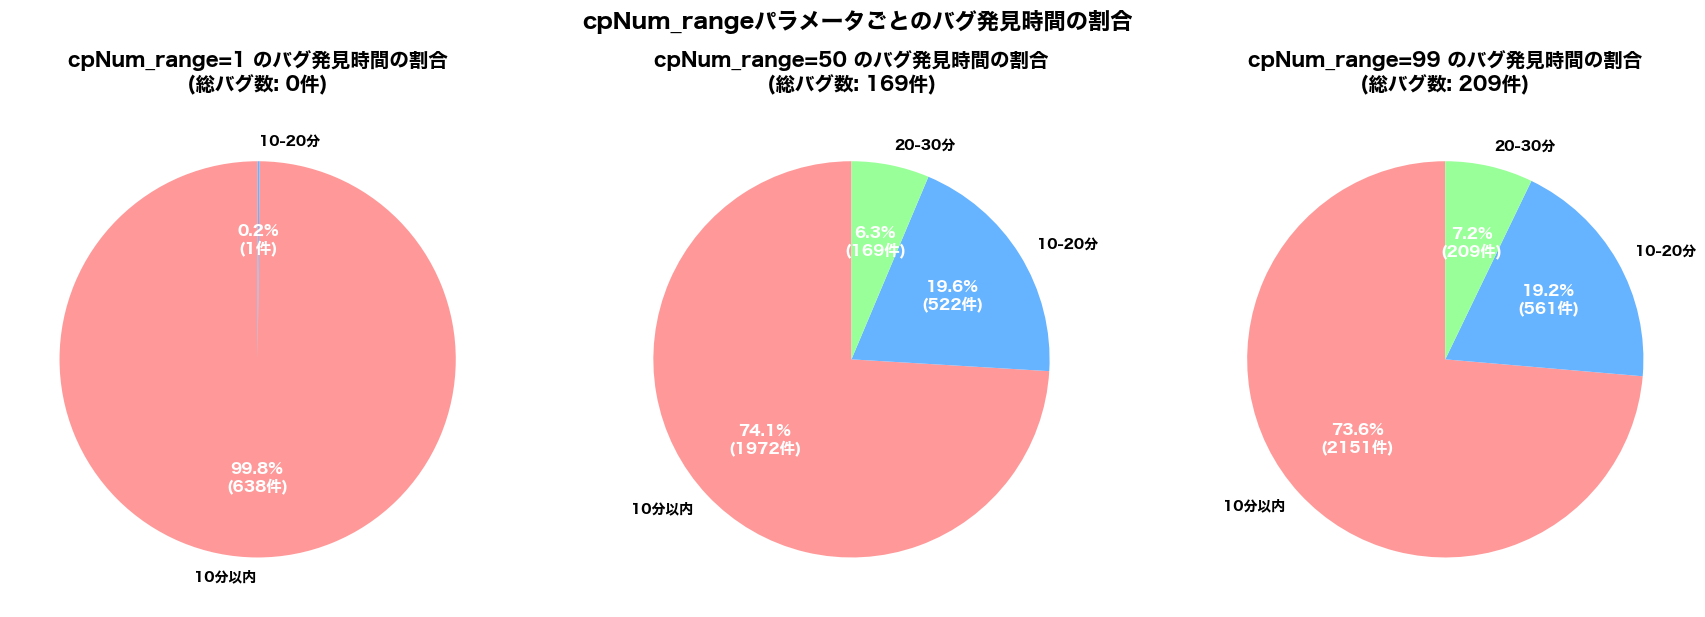

In [69]:
# パラメータごとのバグ発見時間の割合を円グラフで表示
print("="*60)
print("パラメータごとのバグ発見時間の割合を円グラフで表示します")
print("="*60)
extended_analyzer.create_pie_charts_by_parameter()


In [70]:
# 実行時間のカウント分析クラス（tree、cpNum、cpNum_rangeごと）

class ExecutionTimeCounter:
    """実行時間を10分以内、10-20分、20-30分でカウントするクラス"""
    
    def __init__(self):
        """初期化"""
        self.logs_path = 'Logs'
        self.tree_values = [0, 500, 1000]
        self.fps = 60.0  # フレームレート（60fps）
        
        # 時間の閾値（秒単位）
        self.threshold_10min = 10 * 60  # 10分 = 600秒
        self.threshold_20min = 20 * 60  # 20分 = 1200秒
        self.threshold_30min = 30 * 60  # 30分 = 1800秒
        
        # データを格納するリスト
        self.execution_data = []
        
    def parse_directory_name(self, dir_name):
        """ディレクトリ名をパースしてcpNumとcpNum_rangeを抽出"""
        params = dir_name.split(',')
        if len(params) < 30:
            return None, None
            
        try:
            cpnum = None
            cpnum_range = None
            
            # 最初の10個の要素からcpNumを探す
            for i in range(10):
                if int(params[i]) != 0:
                    cpnum = int(params[i])
                    break
                    
            # 次の10個の要素からcpNum_rangeを探す
            for i in range(10, 20):
                if int(params[i]) != 0:
                    cpnum_range = int(params[i])
                    break
            
            return cpnum, cpnum_range
        except (ValueError, IndexError):
            return None, None
    
    def count_execution_times(self, exe_time_path):
        """
        exe_time.csvから実行時間を読み込み、時間帯ごとにカウント
        
        Args:
            exe_time_path: exe_time.csvのパス
        
        Returns:
            dict: 10分以内、10-20分、20-30分の実行回数のカウント結果
        """
        # カウント用の変数を初期化
        count_within_10min = 0  # 10分以内
        count_10_20min = 0      # 10分超20分以内
        count_20_30min = 0      # 20分超30分以内
        
        try:
            # exe_time.csvを読み込んでフレーム数のリストを作成
            with open(exe_time_path, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if line:  # 空行でない場合
                        try:
                            frames = int(line)
                            # フレーム数を秒に変換
                            time_seconds = frames / self.fps
                            
                            # 時間帯ごとにカウント
                            if time_seconds <= self.threshold_10min:
                                count_within_10min += 1
                            elif time_seconds <= self.threshold_20min:
                                count_10_20min += 1
                            elif time_seconds <= self.threshold_30min:
                                count_20_30min += 1
                        except ValueError:
                            # 数値に変換できない場合はスキップ
                            continue
                            
        except FileNotFoundError:
            return None
        except Exception as e:
            print(f"エラーが発生しました: {e}")
            return None
        
        return {
            'within_10min': count_within_10min,
            '10_20min': count_10_20min,
            '20_30min': count_20_30min
        }
    
    def collect_execution_data(self):
        """全てのログディレクトリから実行時間データを収集"""
        # データをリセット
        self.execution_data = []
        
        print("実行時間データの収集を開始しています...")
        
        if not os.path.exists(self.logs_path):
            raise FileNotFoundError(f"ログディレクトリが見つかりません: {self.logs_path}")
        
        total_processed = 0
        total_directories = 0
        
        # 各tree値に対して処理
        for tree in self.tree_values:
            tree_path = os.path.join(self.logs_path, f"tree={tree}")
            
            if not os.path.exists(tree_path):
                print(f"警告: {tree_path} が見つかりません。スキップします。")
                continue
            
            print(f"  tree={tree} のディレクトリを処理中...")
            processed_count = 0
            directories_in_tree = len([d for d in os.listdir(tree_path) 
                                     if os.path.isdir(os.path.join(tree_path, d))])
            total_directories += directories_in_tree
            
            for dir_name in os.listdir(tree_path):
                dir_path = os.path.join(tree_path, dir_name)
                
                if not os.path.isdir(dir_path):
                    continue
                    
                # ディレクトリ名をパース
                cpnum, cpnum_range = self.parse_directory_name(dir_name)
                if cpnum is None or cpnum_range is None:
                    continue
                    
                # exe_time.csvファイルのパス
                exe_time_path = os.path.join(dir_path, 'exe_time.csv')
                
                # 実行時間データを読み込み
                data = self.count_execution_times(exe_time_path)
                if data is None:
                    continue
                
                # データを保存
                self.execution_data.append({
                    'tree': tree,
                    'cpnum': cpnum,
                    'cpnum_range': cpnum_range,
                    'within_10min': data['within_10min'],
                    '10_20min': data['10_20min'],
                    '20_30min': data['20_30min'],
                })
                processed_count += 1
                total_processed += 1
            
            print(f"  tree={tree}: {processed_count}/{directories_in_tree} ディレクトリを処理しました")
            
        print(f"データ収集完了: 合計 {total_processed}/{total_directories} ディレクトリを処理しました")
    
    def print_summary_by_tree(self):
        """treeごとの実行時間カウント結果を表示"""
        if not self.execution_data:
            print("エラー: データが収集されていません。先にcollect_execution_data()を実行してください。")
            return
        
        df = pd.DataFrame(self.execution_data)
        
        print("\n" + "="*80)
        print("Treeごとの実行時間カウント結果")
        print("="*80)
        
        for tree in self.tree_values:
            tree_df = df[df['tree'] == tree]
            
            if len(tree_df) == 0:
                print(f"\ntree={tree}: データなし")
                continue
            
            # 各時間帯の合計を計算
            total_10min = tree_df['within_10min'].sum()
            total_10_20min = tree_df['10_20min'].sum()
            total_20_30min = tree_df['20_30min'].sum()
            total_all = total_10min + total_10_20min + total_20_30min
            
            print(f"\ntree={tree}:")
            print(f"  10分以内: {total_10min:,}回 ({total_10min/total_all*100:.1f}%)")
            print(f"  10-20分: {total_10_20min:,}回 ({total_10_20min/total_all*100:.1f}%)")
            print(f"  20-30分: {total_20_30min:,}回 ({total_20_30min/total_all*100:.1f}%)")
            print(f"  合計: {total_all:,}回")
    
    def print_summary_by_cpnum(self):
        """cpNumごとの実行時間カウント結果を表示"""
        if not self.execution_data:
            print("エラー: データが収集されていません。先にcollect_execution_data()を実行してください。")
            return
        
        df = pd.DataFrame(self.execution_data)
        
        print("\n" + "="*80)
        print("cpNumごとの実行時間カウント結果")
        print("="*80)
        
        # cpNumの値をソート
        cpnum_values = sorted(df['cpnum'].unique())
        
        for cpnum in cpnum_values:
            cpnum_df = df[df['cpnum'] == cpnum]
            
            if len(cpnum_df) == 0:
                print(f"\ncpNum={cpnum}: データなし")
                continue
            
            # 各時間帯の合計を計算
            total_10min = cpnum_df['within_10min'].sum()
            total_10_20min = cpnum_df['10_20min'].sum()
            total_20_30min = cpnum_df['20_30min'].sum()
            total_all = total_10min + total_10_20min + total_20_30min
            
            print(f"\ncpNum={cpnum}:")
            print(f"  10分以内: {total_10min:,}回 ({total_10min/total_all*100:.1f}%)")
            print(f"  10-20分: {total_10_20min:,}回 ({total_10_20min/total_all*100:.1f}%)")
            print(f"  20-30分: {total_20_30min:,}回 ({total_20_30min/total_all*100:.1f}%)")
            print(f"  合計: {total_all:,}回")
    
    def print_summary_by_cpnum_range(self):
        """cpNum_rangeごとの実行時間カウント結果を表示"""
        if not self.execution_data:
            print("エラー: データが収集されていません。先にcollect_execution_data()を実行してください。")
            return
        
        df = pd.DataFrame(self.execution_data)
        
        print("\n" + "="*80)
        print("cpNum_rangeごとの実行時間カウント結果")
        print("="*80)
        
        # cpNum_rangeの値をソート
        cpnum_range_values = sorted(df['cpnum_range'].unique())
        
        for cpnum_range in cpnum_range_values:
            range_df = df[df['cpnum_range'] == cpnum_range]
            
            if len(range_df) == 0:
                print(f"\ncpNum_range={cpnum_range}: データなし")
                continue
            
            # 各時間帯の合計を計算
            total_10min = range_df['within_10min'].sum()
            total_10_20min = range_df['10_20min'].sum()
            total_20_30min = range_df['20_30min'].sum()
            total_all = total_10min + total_10_20min + total_20_30min
            
            print(f"\ncpNum_range={cpnum_range}:")
            print(f"  10分以内: {total_10min:,}回 ({total_10min/total_all*100:.1f}%)")
            print(f"  10-20分: {total_10_20min:,}回 ({total_10_20min/total_all*100:.1f}%)")
            print(f"  20-30分: {total_20_30min:,}回 ({total_20_30min/total_all*100:.1f}%)")
            print(f"  合計: {total_all:,}回")
    
    def create_summary_table(self):
        """実行時間カウント結果を表形式で表示"""
        if not self.execution_data:
            print("エラー: データが収集されていません。先にcollect_execution_data()を実行してください。")
            return
        
        df = pd.DataFrame(self.execution_data)
        
        # treeごとの集計
        tree_summary = df.groupby('tree').agg({
            'within_10min': 'sum',
            '10_20min': 'sum',
            '20_30min': 'sum'
        }).reset_index()
        tree_summary['合計'] = tree_summary['within_10min'] + tree_summary['10_20min'] + tree_summary['20_30min']
        tree_summary.columns = ['tree', '10分以内', '10-20分', '20-30分', '合計']
        
        # cpNumごとの集計
        cpnum_summary = df.groupby('cpnum').agg({
            'within_10min': 'sum',
            '10_20min': 'sum',
            '20_30min': 'sum'
        }).reset_index()
        cpnum_summary['合計'] = cpnum_summary['within_10min'] + cpnum_summary['10_20min'] + cpnum_summary['20_30min']
        cpnum_summary.columns = ['cpNum', '10分以内', '10-20分', '20-30分', '合計']
        
        # cpNum_rangeごとの集計
        cpnum_range_summary = df.groupby('cpnum_range').agg({
            'within_10min': 'sum',
            '10_20min': 'sum',
            '20_30min': 'sum'
        }).reset_index()
        cpnum_range_summary['合計'] = cpnum_range_summary['within_10min'] + cpnum_range_summary['10_20min'] + cpnum_range_summary['20_30min']
        cpnum_range_summary.columns = ['cpNum_range', '10分以内', '10-20分', '20-30分', '合計']
        
        print("\n" + "="*80)
        print("実行時間カウント結果サマリー")
        print("="*80)
        
        print("\n【Treeごと】")
        print(tree_summary.to_string(index=False))
        
        print("\n【cpNumごと】")
        print(cpnum_summary.to_string(index=False))
        
        print("\n【cpNum_rangeごと】")
        print(cpnum_range_summary.to_string(index=False))
        
        return tree_summary, cpnum_summary, cpnum_range_summary
    
    def create_line_charts_by_parameters(self):
        """
        パラメータ（tree、cpNum、cpNum_range）ごとの実行時間の割合を折れ線グラフで表示
        横軸：パラメータの値、縦軸：バグ発見数
        時間帯ごとに3本の折れ線（10分以内、10-20分、20-30分）を描画
        """
        if not self.execution_data:
            print("エラー: データが収集されていません。先にcollect_execution_data()を実行してください。")
            return
        
        df = pd.DataFrame(self.execution_data)
        
        # Treeごとの折れ線グラフを作成
        print("\n=== Treeパラメータごとの折れ線グラフ ===")
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # 時間帯ごとのデータを準備
        bugs_10min_list = []
        bugs_10_20min_list = []
        bugs_20_30min_list = []
        
        for tree in self.tree_values:
            tree_df = df[df['tree'] == tree]
            
            if len(tree_df) == 0:
                bugs_10min_list.append(0)
                bugs_10_20min_list.append(0)
                bugs_20_30min_list.append(0)
                continue
            
            # 各時間帯のバグ数を計算
            total_10min = tree_df['within_10min'].sum()
            total_10_20min = tree_df['10_20min'].sum()
            total_20_30min = tree_df['20_30min'].sum()
            
            bugs_10min_list.append(total_10min)
            bugs_10_20min_list.append(total_10_20min)
            bugs_20_30min_list.append(total_20_30min)
        
        # 時間帯ごとに折れ線グラフを描画
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
        labels = ['10分以内', '10-20分', '20-30分']
        
        ax.plot(self.tree_values, bugs_10min_list, marker='o', linewidth=2.5, markersize=8, 
               label=labels[0], color=colors[0])
        ax.plot(self.tree_values, bugs_10_20min_list, marker='s', linewidth=2.5, markersize=8, 
               label=labels[1], color=colors[1])
        ax.plot(self.tree_values, bugs_20_30min_list, marker='^', linewidth=2.5, markersize=8, 
               label=labels[2], color=colors[2])
        
        # 各ポイントに値を表示
        for i, tree in enumerate(self.tree_values):
            if bugs_10min_list[i] > 0:
                ax.text(tree, bugs_10min_list[i], f'{int(bugs_10min_list[i])}', 
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
            if bugs_10_20min_list[i] > 0:
                ax.text(tree, bugs_10_20min_list[i], f'{int(bugs_10_20min_list[i])}', 
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
            if bugs_20_30min_list[i] > 0:
                ax.text(tree, bugs_20_30min_list[i], f'{int(bugs_20_30min_list[i])}', 
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # グラフの設定
        ax.set_xlabel('Tree', fontsize=12, fontweight='bold')
        ax.set_ylabel('バグ発見数', fontsize=12, fontweight='bold')
        ax.set_title('Treeパラメータごとの実行時間の割合（折れ線グラフ）', fontsize=14, fontweight='bold', pad=15)
        ax.set_xticks(self.tree_values)
        ax.legend(loc='best', fontsize=11)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        # cpNumごとの折れ線グラフを作成
        print("\n=== cpNumパラメータごとの折れ線グラフ ===")
        cpnum_values = sorted(df['cpnum'].unique())
        
        if len(cpnum_values) > 0:
            fig, ax = plt.subplots(figsize=(12, 7))
            
            # 時間帯ごとのデータを準備
            bugs_10min_list = []
            bugs_10_20min_list = []
            bugs_20_30min_list = []
            
            for cpnum in cpnum_values:
                cpnum_df = df[df['cpnum'] == cpnum]
                
                if len(cpnum_df) == 0:
                    bugs_10min_list.append(0)
                    bugs_10_20min_list.append(0)
                    bugs_20_30min_list.append(0)
                    continue
                
                # 各時間帯のバグ数を計算
                total_10min = cpnum_df['within_10min'].sum()
                total_10_20min = cpnum_df['10_20min'].sum()
                total_20_30min = cpnum_df['20_30min'].sum()
                
                bugs_10min_list.append(total_10min)
                bugs_10_20min_list.append(total_10_20min)
                bugs_20_30min_list.append(total_20_30min)
            
            # 時間帯ごとに折れ線グラフを描画
            ax.plot(cpnum_values, bugs_10min_list, marker='o', linewidth=2.5, markersize=8, 
                   label=labels[0], color=colors[0])
            ax.plot(cpnum_values, bugs_10_20min_list, marker='s', linewidth=2.5, markersize=8, 
                   label=labels[1], color=colors[1])
            ax.plot(cpnum_values, bugs_20_30min_list, marker='^', linewidth=2.5, markersize=8, 
                   label=labels[2], color=colors[2])
            
            # 各ポイントに値を表示
            for i, cpnum in enumerate(cpnum_values):
                if bugs_10min_list[i] > 0:
                    ax.text(cpnum, bugs_10min_list[i], f'{int(bugs_10min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
                if bugs_10_20min_list[i] > 0:
                    ax.text(cpnum, bugs_10_20min_list[i], f'{int(bugs_10_20min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
                if bugs_20_30min_list[i] > 0:
                    ax.text(cpnum, bugs_20_30min_list[i], f'{int(bugs_20_30min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # グラフの設定
            ax.set_xlabel('cpNum', fontsize=12, fontweight='bold')
            ax.set_ylabel('バグ発見数', fontsize=12, fontweight='bold')
            ax.set_title('cpNumパラメータごとの実行時間の割合（折れ線グラフ）', fontsize=14, fontweight='bold', pad=15)
            ax.set_xticks(cpnum_values)
            ax.legend(loc='best', fontsize=11)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            plt.tight_layout()
            plt.show()
        
        # cpNum_rangeごとの折れ線グラフを作成
        print("\n=== cpNum_rangeパラメータごとの折れ線グラフ ===")
        cpnum_range_values = sorted(df['cpnum_range'].unique())
        
        if len(cpnum_range_values) > 0:
            fig, ax = plt.subplots(figsize=(10, 7))
            
            # 時間帯ごとのデータを準備
            bugs_10min_list = []
            bugs_10_20min_list = []
            bugs_20_30min_list = []
            
            for cpnum_range in cpnum_range_values:
                range_df = df[df['cpnum_range'] == cpnum_range]
                
                if len(range_df) == 0:
                    bugs_10min_list.append(0)
                    bugs_10_20min_list.append(0)
                    bugs_20_30min_list.append(0)
                    continue
                
                # 各時間帯のバグ数を計算
                total_10min = range_df['within_10min'].sum()
                total_10_20min = range_df['10_20min'].sum()
                total_20_30min = range_df['20_30min'].sum()
                
                bugs_10min_list.append(total_10min)
                bugs_10_20min_list.append(total_10_20min)
                bugs_20_30min_list.append(total_20_30min)
            
            # 時間帯ごとに折れ線グラフを描画
            ax.plot(cpnum_range_values, bugs_10min_list, marker='o', linewidth=2.5, markersize=8, 
                   label=labels[0], color=colors[0])
            ax.plot(cpnum_range_values, bugs_10_20min_list, marker='s', linewidth=2.5, markersize=8, 
                   label=labels[1], color=colors[1])
            ax.plot(cpnum_range_values, bugs_20_30min_list, marker='^', linewidth=2.5, markersize=8, 
                   label=labels[2], color=colors[2])
            
            # 各ポイントに値を表示
            for i, cpnum_range in enumerate(cpnum_range_values):
                if bugs_10min_list[i] > 0:
                    ax.text(cpnum_range, bugs_10min_list[i], f'{int(bugs_10min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
                if bugs_10_20min_list[i] > 0:
                    ax.text(cpnum_range, bugs_10_20min_list[i], f'{int(bugs_10_20min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
                if bugs_20_30min_list[i] > 0:
                    ax.text(cpnum_range, bugs_20_30min_list[i], f'{int(bugs_20_30min_list[i])}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # グラフの設定
            ax.set_xlabel('cpNum_range', fontsize=12, fontweight='bold')
            ax.set_ylabel('バグ発見数', fontsize=12, fontweight='bold')
            ax.set_title('cpNum_rangeパラメータごとの実行時間の割合（折れ線グラフ）', fontsize=14, fontweight='bold', pad=15)
            ax.set_xticks(cpnum_range_values)
            ax.legend(loc='best', fontsize=11)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            plt.tight_layout()
            plt.show()

# 実行時間カウントクラスのインスタンスを作成
execution_counter = ExecutionTimeCounter()


In [71]:
# 実行時間データの収集
execution_counter.collect_execution_data()


実行時間データの収集を開始しています...
  tree=0 のディレクトリを処理中...
  tree=0: 720/720 ディレクトリを処理しました
  tree=500 のディレクトリを処理中...
  tree=500: 720/720 ディレクトリを処理しました
  tree=1000 のディレクトリを処理中...
  tree=1000: 720/720 ディレクトリを処理しました
データ収集完了: 合計 2160/2160 ディレクトリを処理しました


In [72]:
# 実行時間カウント結果の表示（treeごと、cpNumごと、cpNum_rangeごと）

# Treeごとの結果
execution_counter.print_summary_by_tree()

# cpNumごとの結果
execution_counter.print_summary_by_cpnum()

# cpNum_rangeごとの結果
execution_counter.print_summary_by_cpnum_range()

# 表形式のサマリー
tree_summary, cpnum_summary, cpnum_range_summary = execution_counter.create_summary_table()



Treeごとの実行時間カウント結果

tree=0:
  10分以内: 2,406回 (66.8%)
  10-20分: 621回 (17.2%)
  20-30分: 573回 (15.9%)
  合計: 3,600回

tree=500:
  10分以内: 2,830回 (78.6%)
  10-20分: 473回 (13.1%)
  20-30分: 297回 (8.2%)
  合計: 3,600回

tree=1000:
  10分以内: 2,724回 (75.7%)
  10-20分: 522回 (14.5%)
  20-30分: 354回 (9.8%)
  合計: 3,600回

cpNumごとの実行時間カウント結果

cpNum=1:
  10分以内: 1,799回 (99.9%)
  10-20分: 0回 (0.0%)
  20-30分: 1回 (0.1%)
  合計: 1,800回

cpNum=50:
  10分以内: 1,325回 (73.6%)
  10-20分: 275回 (15.3%)
  20-30分: 200回 (11.1%)
  合計: 1,800回

cpNum=99:
  10分以内: 1,340回 (74.4%)
  10-20分: 245回 (13.6%)
  20-30分: 215回 (11.9%)
  合計: 1,800回

cpNum=200:
  10分以内: 1,328回 (73.8%)
  10-20分: 251回 (13.9%)
  20-30分: 221回 (12.3%)
  合計: 1,800回

cpNum=300:
  10分以内: 1,242回 (69.0%)
  10-20分: 357回 (19.8%)
  20-30分: 201回 (11.2%)
  合計: 1,800回

cpNum=700:
  10分以内: 926回 (51.4%)
  10-20分: 488回 (27.1%)
  20-30分: 386回 (21.4%)
  合計: 1,800回

cpNum_rangeごとの実行時間カウント結果

cpNum_range=1:
  10分以内: 2,945回 (81.8%)
  10-20分: 477回 (13.2%)
  20-30分: 178回 (4.9%)
  合計: 3,600回


パラメータごとの実行結果を折れ線グラフで表示します

=== Treeパラメータごとの折れ線グラフ ===


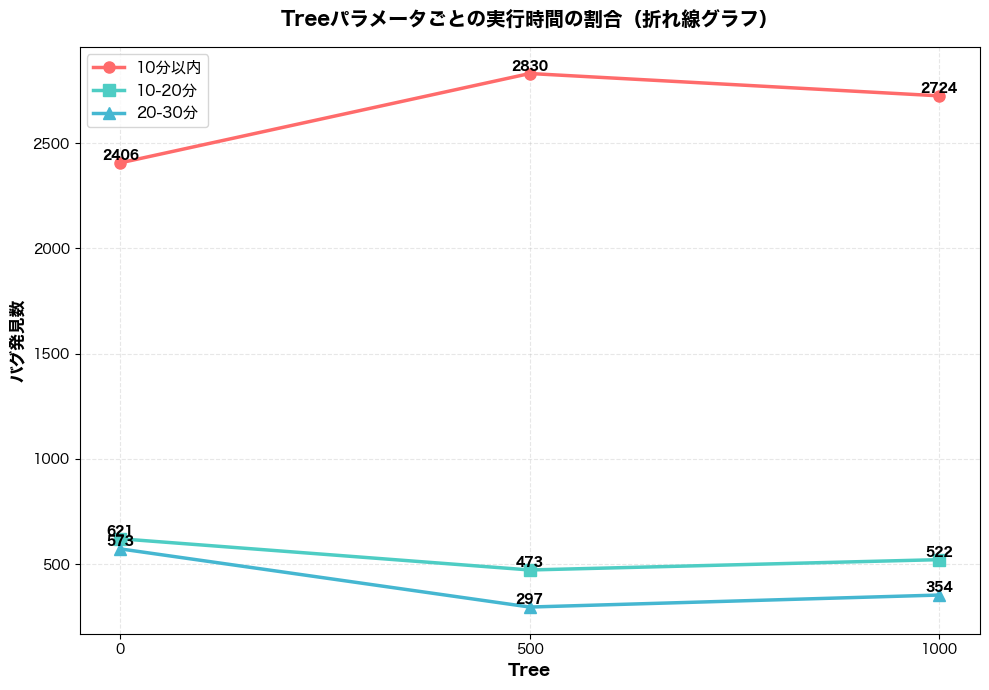


=== cpNumパラメータごとの折れ線グラフ ===


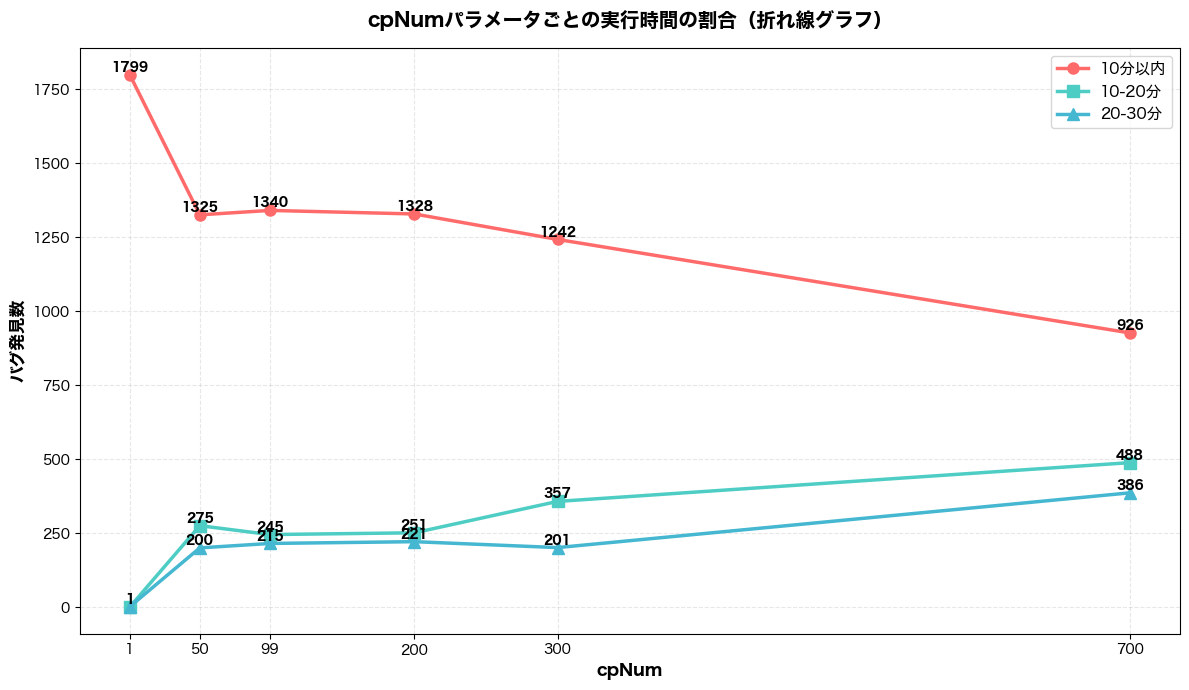


=== cpNum_rangeパラメータごとの折れ線グラフ ===


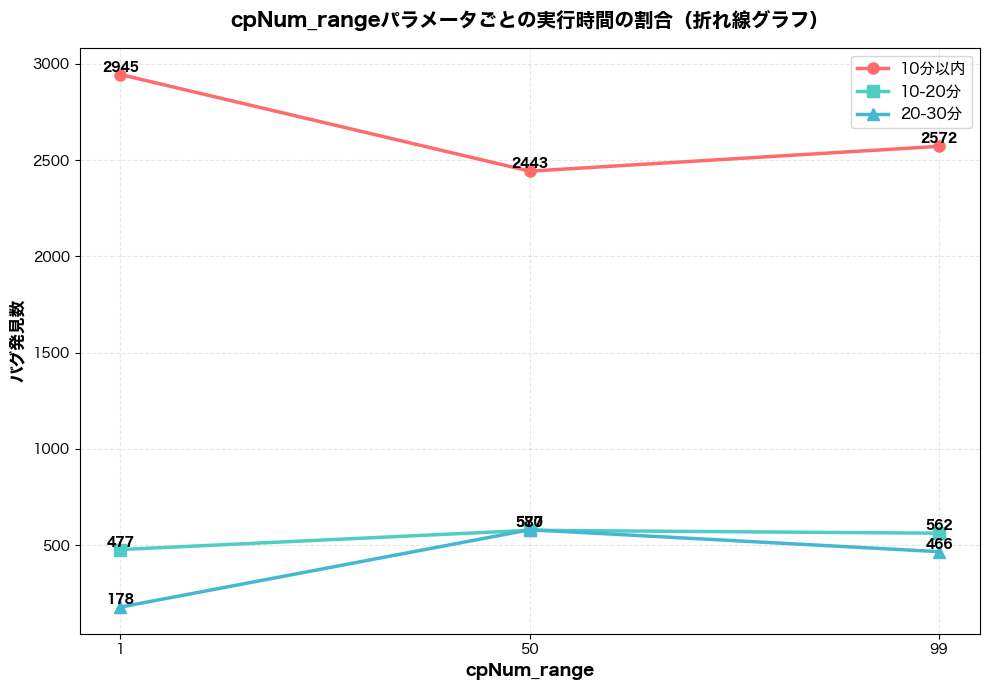

In [73]:
# セル10のデータを折れ線グラフで表示
print("="*60)
print("パラメータごとの実行結果を折れ線グラフで表示します")
print("="*60)
execution_counter.create_line_charts_by_parameters()
